In [11]:
# pip install geopandas shapely networkx pyproj
import geopandas as gpd
from shapely.ops import unary_union, linemerge
from shapely.geometry import LineString, MultiLineString, Point
import networkx as nx


shp_path = r"C:\Users\telukkari\Downloads\KANTA-HAME\KANTA-HAME\DR_LINKKI_K.shp"  

gdf = gpd.read_file(shp_path)   

gdf = gdf.set_geometry(gdf.geometry).dropna(subset=["geometry"])
gdf = gdf.explode(index_parts=False)           


if gdf.crs is None:
    raise ValueError("Your shapefile has no CRS. Set it before proceeding.")
if gdf.crs.is_geographic:
    # pick a suitable local projection; 3857 is OK-ish for quick demos
    gdf = gdf.to_crs(3067)


c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


In [12]:
# unary_union builds a single noded network; linemerge collapses into simple LineStrings
merged = linemerge(unary_union(gdf.geometry.tolist()))

# Normalize to an iterable of LineStrings
if isinstance(merged, LineString):
    segments = [merged]
elif isinstance(merged, MultiLineString):
    segments = list(merged.geoms)
else:
    raise ValueError("Unexpected geometry after noding.")

seg_gdf = gpd.GeoDataFrame(geometry=segments, crs=gdf.crs)


In [13]:
def _round_xy(x, y, ndigits=3):
    # tolerance to de-duplicate nearly-identical vertices (units = CRS units)
    return (round(float(x), ndigits), round(float(y), ndigits))

G = nx.Graph()   # use nx.DiGraph() if you need direction

for i, geom in enumerate(seg_gdf.geometry):
    if geom.is_empty:
        continue
    if not isinstance(geom, LineString):
        # safety: skip anything that isn't a LineString
        continue

    # endpoints = network nodes
    x1, y1, z1 = geom.coords[0]
    x2, y2, z2 = geom.coords[-1]
    n1 = _round_xy(x1, y1)
    n2 = _round_xy(x2, y2)

    # add nodes with position attributes (handy for plotting)
    if n1 not in G:
        G.add_node(n1, x=n1[0], y=n1[1])
    if n2 not in G:
        G.add_node(n2, x=n2[0], y=n2[1])

    # edge attributes
    length = geom.length
    G.add_edge(n1, n2,
               geometry=geom,   # keep the LineString
               length=length)   # weight for routing


In [14]:
components = list(nx.connected_components(G))
largest = max(components, key=len)
print(f"{len(components)} components; largest has {len(largest)} nodes")


175 components; largest has 73106 nodes


In [15]:
bc = nx.betweenness_centrality(G, weight="length", normalized=True, k=150)  # sample for speed on big graphs
# attach to nodes if you like:
nx.set_node_attributes(G, bc, "betweenness")

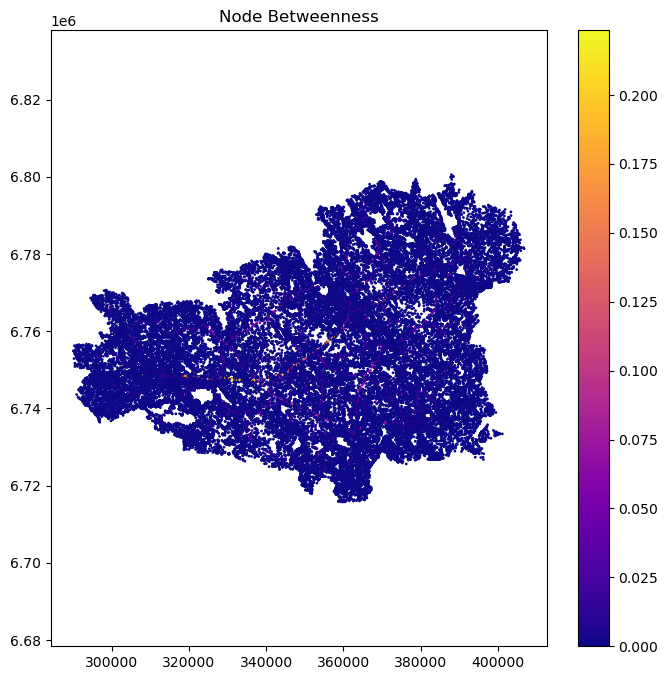

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

nodes = list(G.nodes())
nodes_gdf = gpd.GeoDataFrame(
    {"bc": [G.nodes[n].get("betweenness", 0) for n in nodes]},
    geometry=[Point(*n) for n in nodes],  # unpack tuple (x, y)
    crs="EPSG:3067" # replace with your CRS
)

ax = nodes_gdf.plot(
    column="bc",
    cmap="plasma",
    markersize=1,
    legend=True,
    figsize=(8, 8)
)

plt.xlim([396000, 399500])
plt.ylim([6783700,6788500])

plt.title("Node Betweenness")
plt.axis("equal")
plt.show()


<Axes: >

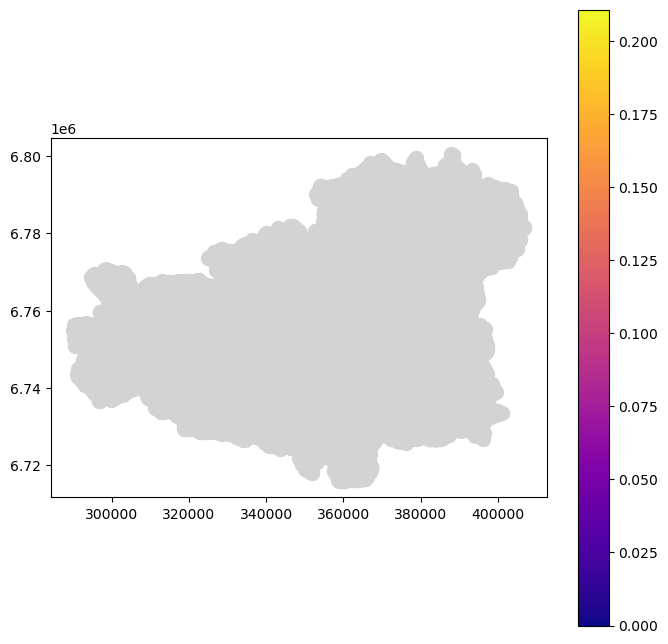

In [8]:
import geopandas as gpd
from shapely.geometry import Point

# Nodes
nodes_gdf = gpd.GeoDataFrame(
    {"bc": [d.get("betweenness", 0) for _, d in G.nodes(data=True)]},
    geometry=[Point(n) for n in G.nodes()],
    crs="EPSG:3857"  # replace with your CRS
)

# Plot
ax = nodes_gdf.plot(
    column="bc",
    cmap="plasma",
    markersize=1,
    legend=True,
    figsize=(8,8)
)

# u_list, v_list, geoms, lengths = [], [], [], []
# for u, v, data in G.edges(data=True):
#     u_list.append(u)
#     v_list.append(v)
#     geoms.append(data["geometry"])   # assuming you stored shapely LineString when building G
#     lengths.append(data.get("length", None))

# edges_gdf = gpd.GeoDataFrame(
#     {"u": u_list, "v": v_list, "length": lengths},
#     geometry=geoms,
#     crs="EPSG:3857"  # replace with your CRS
# )

nodes_gdf.plot(ax=ax, color="lightgray", linewidth=5)
